# Giriş
Bu projenin amacı: 7 farklı göz hastalıkları hücresinin mikroskobik fotoğraflarının makine öğrenimi yöntemlerini kullanarak işlenip, verilen görsellerin hangi göz hastalığı grubuna ait olduğunu  tahmin eden, yüksek başarımlı bir makine öğrenim modeli oluşturulması hedeflenmektedir.


# İçindekiler
* [Veri Setini Anlamak](#veri-setini-anlamak)
* [Veriyi Okumak](#veriyi-okumak)
    * [Dosya İşlemleri](#dosya-islemleri)
* [Keşifsel Veri Analizi](#kesifsel-veri-analizi)
    * [Dengesiz Verilerin Düzenlenmesi](#dengesiz-veriler)
    * [Aykırı Değer (Outlier) Tespiti ve Yönetimi](#veriyi-okumak)
    * [Normalizasyon İşlemleri](#normalizasyon-islemleri)
    * [İlişkili Verilerin Bulunması (Corelation)](#veriyi-okumak)
    
* [Model Seçimi](#veriyi-okumak)
    * [En İyi Parametrelerin Bulunması](#veriyi-okumak)
    * --
    * --
    * --
* [Sonuç Değerlendirmesi](#veriyi-okumak)

## Veri Setini Anlamak <a class="anchor" id="veri-setini-anlamak"></a>
Çalışacağımız veri seti "Ocular Disease Recognition" Normal, Cataract, Diabetes, Age related Macular degeneration, Pathological Myopia ve Glaucoma retina görsellerini barındırır. 
. Sırasıyla retinal türlerin açıklaması aşağıdaki gibidir.
- Normal (N) : Herhangi bir anomalite bulundurmayan sağlıklı göz dokusu.
- Diabetes (D) : Glukoz seviyesinin aşırı derecede yükselmesiyle (hiperglisemi) sonuçlanan metabolik bir bozukluk sebebiyle körlük yapabilen hastalık.[1]
- Glaucoma (G) : Optik sinirde (veya retina da ) hasarla sonuçlanan ve görme kaybına neden olan bir grup göz hastalığıdır.[2]
- Cataract (C) :  Doğal göz merceğinin matlaşması ve yüzeyinde oluşan çeşitli lekelenmelerle birlikte saydamlığını yitirmesiyle oluşan bir göz hastalığıdır.[3]
- Age related Macular Degeneration (A) : Halk arasında "sarı nokta hastalığı" diye bilinen "yaşa bağlı makula dejenerasyonu" zamanla ilerleyerek makulayı tamamen hasara uğratabilen dejeneratif bir hastalıktır.[4]
- Hypertension (H) : Yüksek kan basıncının retinada yaptığı hasara hipertansif retinopati denir.[5]
- Pathological Myopia (M) : Patolojik miyopi, aşırı yüksek miyopik kusurun neden olduğu ve ciddi göz hastalıklarına yol açabilen bir hastalıktır.
- Other diseases/abnormalities (O) : Yukarıda olmayan diğer anormallikler ve rahatszılıklar.

## Veriyi Okumak <a class="anchor" id="veriyi-okumak"></a>

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings 
import os
from PIL import Image

### Dosya İşlemleri <a class="anchor" id="dosya-islemleri"></a>

In [3]:
df = pd.read_csv("full_df.csv")
df.head

<bound method NDFrame.head of         ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
0        0           69      Female     0_left.jpg     0_right.jpg   
1        1           57        Male     1_left.jpg     1_right.jpg   
2        2           42        Male     2_left.jpg     2_right.jpg   
3        4           53        Male     4_left.jpg     4_right.jpg   
4        5           50      Female     5_left.jpg     5_right.jpg   
...    ...          ...         ...            ...             ...   
6387  4686           63        Male  4686_left.jpg  4686_right.jpg   
6388  4688           42        Male  4688_left.jpg  4688_right.jpg   
6389  4689           54        Male  4689_left.jpg  4689_right.jpg   
6390  4690           57        Male  4690_left.jpg  4690_right.jpg   
6391  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
0                                              cataract   
1          

In [4]:
df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

ID sütunları gereksiz. Niceliklerin birbiri ile ilişkisine herhangi bir faydası yok. O yüzden drop edilmesi gerekiyor.

In [5]:
df.drop(['ID'], inplace = True, axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Patient Age                6392 non-null   int64 
 1   Patient Sex                6392 non-null   object
 2   Left-Fundus                6392 non-null   object
 3   Right-Fundus               6392 non-null   object
 4   Left-Diagnostic Keywords   6392 non-null   object
 5   Right-Diagnostic Keywords  6392 non-null   object
 6   N                          6392 non-null   int64 
 7   D                          6392 non-null   int64 
 8   G                          6392 non-null   int64 
 9   C                          6392 non-null   int64 
 10  A                          6392 non-null   int64 
 11  H                          6392 non-null   int64 
 12  M                          6392 non-null   int64 
 13  O                          6392 non-null   int64 
 14  filepath

In [32]:
result = df[df["H"] == 1].shape
result

(203, 19)

Makine öğrenmesi algoritmaları sadece nümerik veriler üzerinden çalışır. Kategorik veriler olan hastalık türlerinin nümerik verilere dönüştürmek için scikit-learn içerisindeki Label Encoder fonksiyonundan faydalanabilirz.

In [7]:
from sklearn.preprocessing import LabelEncoder
SIZE=32

le = LabelEncoder()
le.fit(df['labels'])
LabelEncoder()
print(list(le.classes_))

["['A']", "['C']", "['D']", "['G']", "['H']", "['M']", "['N']", "['O']"]


In [14]:
df['tags'] = le.transform(df["labels"]) 
print(df.sample(10))

      Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
2789           55      Female  4220_left.jpg  4220_right.jpg   
748            55      Female   868_left.jpg   868_right.jpg   
4175           54      Female  1186_left.jpg  1186_right.jpg   
3577           59        Male   445_left.jpg   445_right.jpg   
3831           77        Male   735_left.jpg   735_right.jpg   
1888           55        Male  2743_left.jpg  2743_right.jpg   
4483           68        Male  1831_left.jpg  1831_right.jpg   
3911           59        Male   822_left.jpg   822_right.jpg   
3673           52        Male   558_left.jpg   558_right.jpg   
6127           58      Female  4371_left.jpg  4371_right.jpg   

                               Left-Diagnostic Keywords  \
2789             moderate non proliferative retinopathy   
748                             myelinated nerve fibers   
4175                        macular epiretinal membrane   
3577                severe nonproliferative retinopathy   


Veri setimizde null değer olmadığı için missing values methodolojilerini uygulamıza gerek kalmadı.

## Keşifsel Veri Analizi (Exploratory Data Analysis) <a class="anchor" id="kesifsel-veri-analizi"></a>

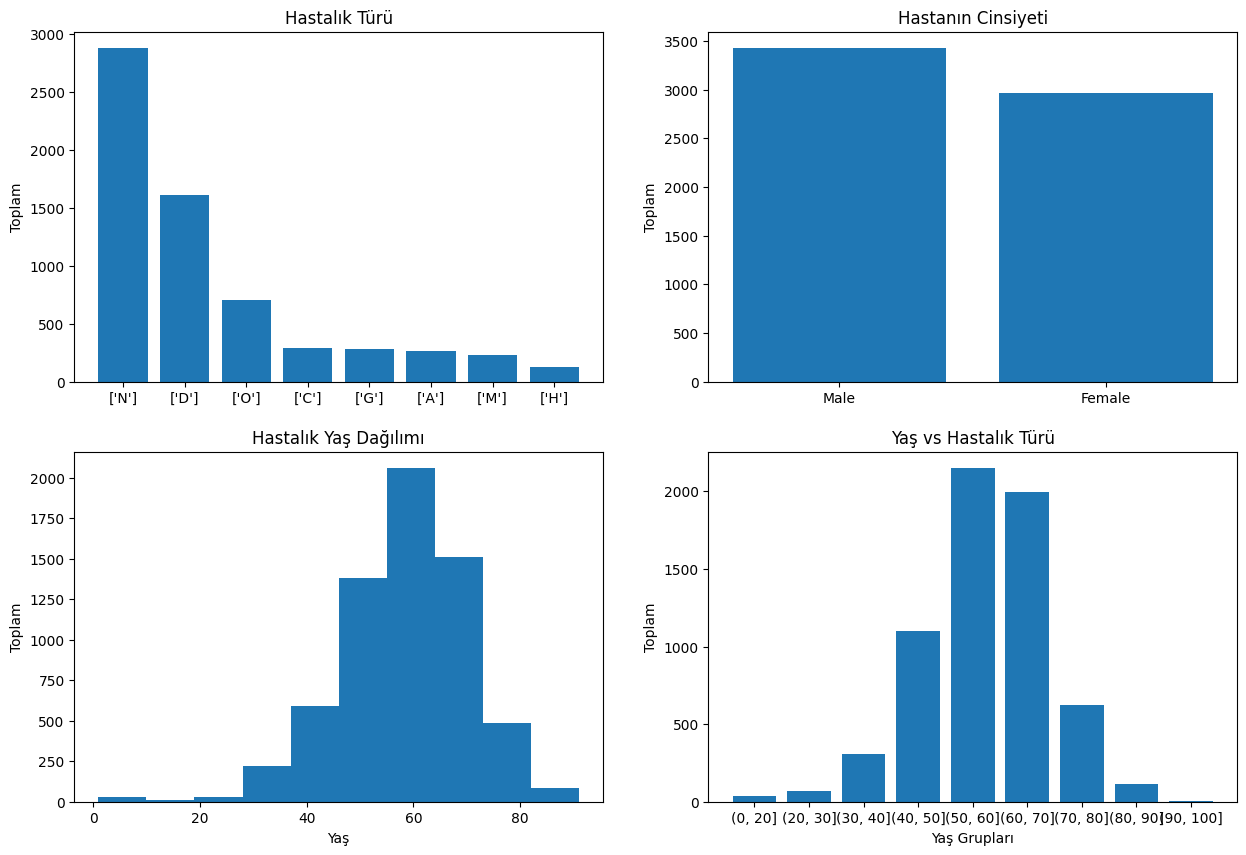

In [8]:

age_groups = pd.cut(df['Patient Age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100])
age_counts = age_groups.value_counts(sort=False)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs[0, 0].bar(df['labels'].value_counts().index, df['labels'].value_counts().values)
axs[0, 0].set_title('Hastalık Türü')
axs[0, 0].set_ylabel('Toplam')

axs[0, 1].bar(df['Patient Sex'].value_counts().index, df['Patient Sex'].value_counts().values)
axs[0, 1].set_title('Hastanın Cinsiyeti')
axs[0, 1].set_ylabel('Toplam')

axs[1, 0].hist(df['Patient Age'], bins=10)
axs[1, 0].set_title('Hastalık Yaş Dağılımı')
axs[1, 0].set_xlabel('Yaş')
axs[1, 0].set_ylabel('Toplam')

axs[1, 1].bar(age_counts.index.astype(str), age_counts.values)
axs[1, 1].set_title('Yaş vs Hastalık Türü')
axs[1, 1].set_xlabel('Yaş Grupları')
axs[1, 1].set_ylabel('Toplam')

plt.show()


Üstteki çizimlerden anlaşılacağı üzere hangi hastalığın ne kadar görüldüğü, yaşa bağlı hastalıkların görülme sıklığını ve cinsiyete göre dağılımlarını rahatça görebiliriz. Aynı zamanda sınıflandırma yapmadan önce verilerin dengeli olması gerekli ki, modelimiz farklı hastalık türünü eğitmeye çalışırken farklı ağırlıklar vermesin. Örneğin bizim verimizde N (Normal) şeklindme tanımlanan grup veri setinde en fazla olduğu için modelimiz N grubuna daha yüksek ağırlık verecek ama test için verdiğimiz verilerde bir veri grubunun diğerinden önceliği olmaması gereklidir. Bunu önlemek için örnek sayılarını(özellikle de hastalık türlerini) dengeli hale getirmeleyiz.

### Dengesiz Verilerin Düzenlenmesi <a class="anchor" id="dengesiz-veriler"></a>

Dengesiz verilerin düzenlenmesi için birçok farklı strateji bulunmakta. Bizim verisetimizde Normal verilerin oranı çok yüksek ama hastalık oranları (özellikle C, G, A, M ve H etiketleri olanlar) düşük olduğu için az sayıdaki örneklem üzerinden oversample etmemiz gerekmekte. Veri setimizdeki hastalık değerlerimizden en küçük olana göre de alabilirdik ama örneklerimizden çoğundan feragat etmemiz gerekebilirdi. Bu yüzden oversample metotlarından biri olan Random Over Sampler metodunun kullanıldı. Bunun yanı sıra scikit-learn içerisindeki resample paketini de kullanabilirdik. Fakat resample modülü overfittingi sorununa yol açabilir çünkü mevcut verisetindeki düşük etiketli verileri ortak bir sayıda alabilecek şekilde tekrarlar. Bunun sonucunda da modelde overfit(ezberleme) sorunu meydana gelebilir. 
TODO: Oluşturulan sentetik veriler , makine öğrenimi modeli oluşturuldıktan sonra ,başka balancing metotlarla test edilecek.

In [29]:
from imblearn.over_sampling import RandomOverSampler
#Random Over Sampler ile dengelenen data
#hastalık türleri
a = df.drop('labels', axis=1) 
#
b = df['labels']

resamp = RandomOverSampler()
dataA , dataB = resamp.fit_resample(a,b)

0       ['N']
1       ['N']
2       ['D']
3       ['D']
4       ['D']
        ...  
6387    ['D']
6388    ['D']
6389    ['D']
6390    ['D']
6391    ['H']
Name: labels, Length: 6392, dtype: object


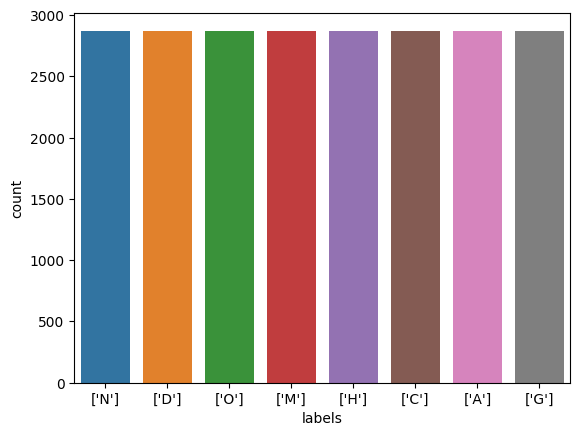

(22984,)

In [10]:
sns.countplot(x = dataB)
plt.show()
dataB.shape

Veri setimizdeki tüm hastalıkları N (Normal) grubu sayısında random olacak şekilde oversample yaparak çoğalttık. Veri setindeki hastalık gurupları artık dengeli.

In [30]:
#En kucuk hastalik turune gore trimlenmis dengeli veri
from imblearn.under_sampling import RandomUnderSampler
a = df.drop('labels', axis=1) 

b = df['labels']

resamp = RandomUnderSampler()
dataA , dataB = resamp.fit_resample(a,b)

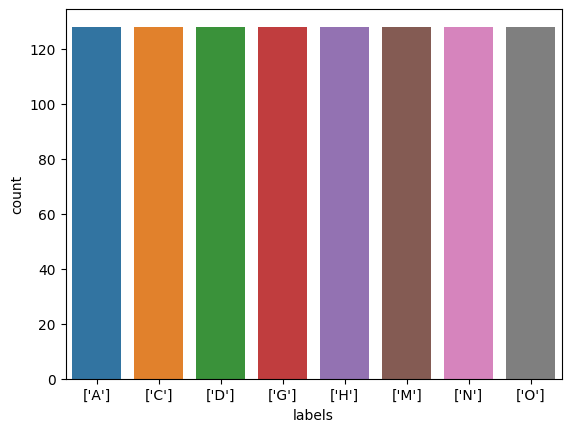

(1024,)

In [31]:
sns.countplot(x = dataB)
plt.show()
dataB.shape

### Normalizasyon İşlemleri <a class="anchor" id="normalizasyon-islemleri"></a>

Öncelikle describe metoduyla veriler arasındaki scale farkına bakılır. Örneğin verilerin ortalama değerleri arasına fazla fark var. Verilerin standartazitaion (standartize) edilmesi gerekli. Kaggle'daki tanımda missing value yok olarak belirtilmiş ki dizindeki 0 değerlerinin anlamsız veri olmadığını ve düzenleme yapılması gerekmediğini anlayabiliyoruz.

In [24]:
df.describe()

,Patient Age,N,D,G,C,A,H,M,O,tags
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436,4.415989
std,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139,2.188106
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


Veriler arasındaki ilişkiyi görebilmek için korelasyon matrisi çizdirilir ve belli bir eşik değerinin üzerindeki değerlere göre veriler üzerinde manipülasyonlar gerçekleştirilir.

In [16]:
corr_matrix = df.corr()
print(corr_matrix)

             Patient Age         N         D         G         C         A  \
Patient Age     1.000000 -0.066672 -0.091023  0.100070  0.190199  0.058467   
N              -0.066672  1.000000 -0.493453 -0.180067 -0.181273 -0.160372   
D              -0.091023 -0.493453  1.000000 -0.104401 -0.081437 -0.112809   
G               0.100070 -0.180067 -0.104401  1.000000 -0.050645  0.000557   
C               0.190199 -0.181273 -0.081437 -0.050645  1.000000 -0.059374   
A               0.058467 -0.160372 -0.112809  0.000557 -0.059374  1.000000   
H              -0.026488 -0.126728  0.040872  0.008842 -0.032218 -0.008731   
M              -0.025278 -0.156902 -0.102116 -0.018233 -0.058089 -0.037930   
O               0.071769 -0.402307 -0.023391 -0.030945 -0.065428 -0.088540   
tags           -0.041342  0.506591 -0.513475 -0.121215 -0.278699 -0.384099   

                    H         M         O      tags  
Patient Age -0.026488 -0.025278  0.071769 -0.041342  
N           -0.126728 -0.156902 -

/tmp/ipykernel_3514/3083230406.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Text(0.5, 1.0, 'Özellikler Arasındaki Kolerasyon')

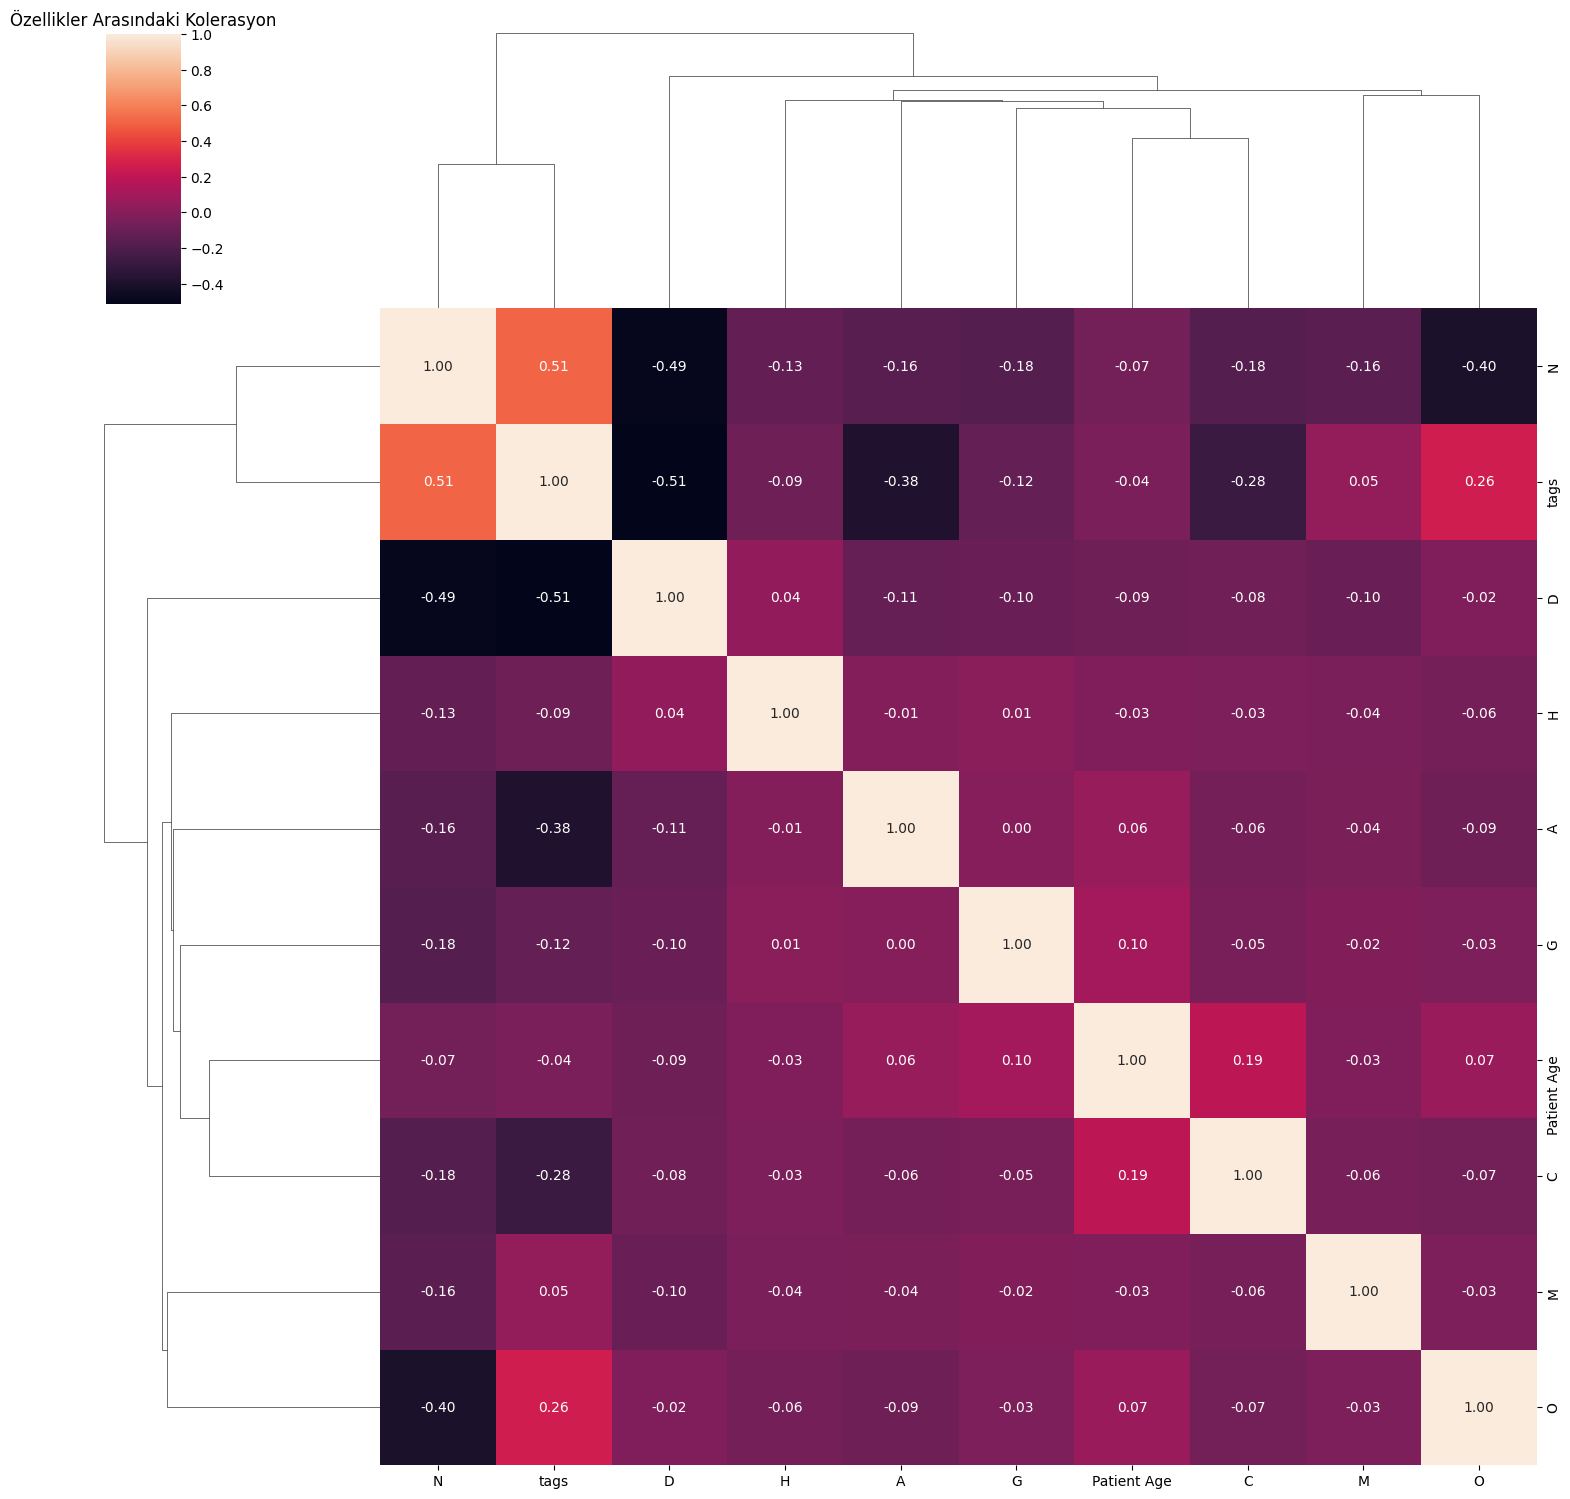

In [17]:
#Korelasyon sonuclarinin cluster map ile gosterimi. annot ile degerler gösterilir, fmt ile virgulden sonra ilk 2 basamak gosterilir.
sns.clustermap(corr_matrix, annot = True, fmt = ".2f", figsize=(15,15))
plt.title("Özellikler Arasındaki Kolerasyon")


### Yapılacaklar Listesi
Kategorik verileri target içerisinde tüm hastalık türleri için one hot encoding işlemi veri seti içinde tanımlı. Veri setine göre Hastalık türlerinin sayısı dengesiz olarak dağılmış.
- Görsel verilerin aynı şekilde formatlandırılması (boyut, renk olabilir olmayadabililir vb.)
- TODO: Hue plot çizimi (standaritzasyon işlemin önce ve sonra )
- TODO: Verilerin bias dağılımları düzenlenecek şekilde resample edilecek.
- TODO: Veri standartizasyon işlemleri.
- TODO: Outlier ve Skewness Kontrolü.


# Kaynakça
 TODO: Kaynakça kısmı örnek bitirme tezlerine bakılarak tekrar düzenlenecek.
- [1]-https://tr.wikipedia.org/wiki/Diyabet
- [2]-https://en.wikipedia.org/wiki/Glaucoma
- [3]-https://venividigoz.com/katarakt-nedir-belirtileri-nelerdir
- [4]-https://www.istanbulretina.com/yasa-bagli-makula-dejenerasyonu-riski.php#:~:text=Halk%20aras%C4%B1nda%20%22sar%C4%B1%20nokta%20hastal%C4%B1%C4%9F%C4%B1,alan%C4%B1n%C4%B1n%20ortas%C4%B1nda%20karama%20ortaya%20%C3%A7%C4%B1kar.
- [5]-https://www.istanbulretina.com/hipertansif-retinopati-hastalik-belirtisi-tedavisi.php



Yazım Kuralları:
- Ana başlıklar tek diez (#)
- Alt başlıklar iki diez(##)
- Alt başlığın alt başlıklarıan üç diez (###)
- Table of content için a class anchor id ler ise küçük ve boşluklar tireli olarak adlandırılacakarv Veri Seti başlığı idsi id=veri-seti gibi.